In [1]:
# import CartPole.py from local directory
import CartPole, sf3utility
import matplotlib.collections
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate, scipy.stats.qmc, scipy.optimize
import random, copy, time

plt.rcParams["font.family"] = "Georgia"
#plt.rcParams['figure.figsize'] = [9.0, 7.0]
#plt.rcParams['figure.dpi'] = 400

# store results for later
cache = {}

%matplotlib notebook

In [2]:
N = 512 * 8

# set the random seed and create the sobol sequence generator
sobol_engine = scipy.stats.qmc.Sobol( d=5, seed=4 )

# get M initial states spaced in the recommended ranges
X = X_sobol = initial_states = (sobol_engine.random_base2( m=int(np.log2(N)) ) - 0.5 ) * 2 * np.array( [ 10, 20, np.pi, 20, 15 ] )
#X = X_sobol = initial_states = (sobol_engine.random_base2( m=int(np.log2(N)) ) - 0.5 ) * 2 * np.array( [ 2, 2, 1, 2, 1 ] ) + np.array([0,0,np.pi,0,0])
#X[:,2] = np.array( [ CartPole.remap_angle(theta) for theta in X[:,2] ] )

# generate the changes in state from these states
Y = np.array( [ CartPole.perform_action5( state ) - state for state in initial_states ] )


M = 32 * 32
kernel_centres = X[:M]


sigma = np.std( X, axis=0 )

def K( X, Xp, sigma = sigma ):
    
    # get squared differences and substitute angle one for periodic version
    d2 = ( (X - Xp) / sigma ) ** 2
    d2[:,0] = 0
    d2[:,2] = (np.sin( 0.5 * ( X[:,2] - Xp[:,2] ) ) / sigma[2] ) ** 2
    
    # divide rows by 2 sigma and return exponential of negative sum along rows
    return np.exp( - 0.5 * np.sum( d2, axis=1 ) )
    
    
# loop over the kernel centres and evaluate the K function across all the Xs at each
Kmn = np.zeros( (M,N) )
for i, kernel_centre in enumerate( kernel_centres ):
    
    Kmn[i] = K( X, kernel_centre[np.newaxis] )
    
# same as above but only use first M vectors from X
Kmm = np.zeros( (M,M) )
for i, kernel_centre in enumerate( kernel_centres ):
    
    Kmm[i] = K( X[:M], kernel_centre[np.newaxis] )
    
    
l = 1e-4

KmnKnm = Kmn @ Kmn.T
a = KmnKnm + l * Kmm
b = Kmn @ Y

alpha_m = np.linalg.lstsq( a, b, rcond=None )[0]

def nonlinear_model( state ):
    
    kernels = K( state[np.newaxis], kernel_centres )
    
    weighted_sums = kernels @ alpha_m
    
    return weighted_sums.squeeze()

In [8]:
unbounded_loss = lambda state : np.linalg.norm( state[:4] * np.array([0.4, 0.2, 1, 0.2]) )

In [43]:

def estimate_next_loss( state, action ):
    
    adj_state = state[:]
    adj_state[4] = action
    state = adj_state + nonlinear_model(adj_state)
    
    return unbounded_loss( state )


def estimate_next_losses( state, actions ):
    
    loss = 0
    
    for action in actions:
        
        adj_state = state[:]
        adj_state[4] = action
        state = adj_state + nonlinear_model(adj_state)
        loss += unbounded_loss( state )

    return loss


<IPython.core.display.Javascript object>


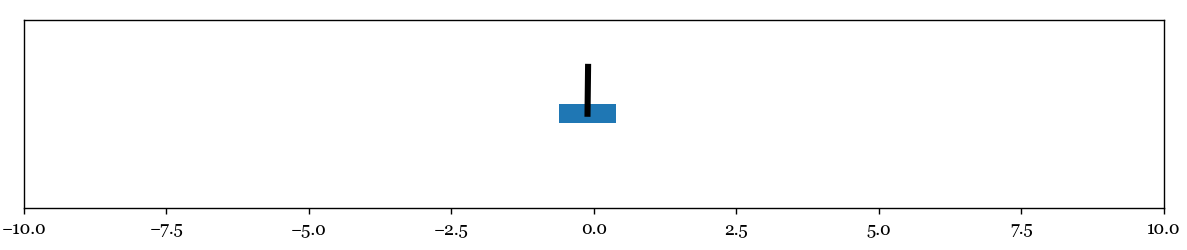

In [50]:
cart_pole = CartPole.CartPole( visual=True, save_frames=False, fig_num=58 )

In [89]:
state = np.array( [ 0, 0, np.pi, 0, 0 ] )
cart_pole.set_state( state )
cart_pole._render()

time.sleep(1)

for i in range(200):
    
    state[4] = forces[i]
    
    state = CartPole.perform_action_RK4( state )
    cart_pole.set_state( state[:4] )
    cart_pole._render()
    
    if abs(CartPole.remap_angle(state[2])) < 0.4 and abs(state[1]) < 2.5 and abs(state[3]) < 2.5:
        break
        

linear_p = np.array( [0.75971638, 1.44284499, 17.05744679, 2.66183469] )
    
for i in range(50):
    
    clipped_state = state[:]
    clipped_state[0] = np.clip(clipped_state[0], -0.5, 0.5)

    state[4] = linear_p @ clipped_state[:4]
    
    state = CartPole.perform_action_RK4( state )
    cart_pole.set_state( state[:4] )
    cart_pole._render()

In [64]:
state = np.array( [ 0, 0, np.pi, 0, 0 ] )
cart_pole.set_state( state )
cart_pole._render()

#states = []

def find_action( state ):
    
    actions = np.linspace( -20, 20, num=11 )
    
    actionses = np.array(np.meshgrid( actions, actions, actions, actions, actions )).T.reshape( (-1,5) )
    losses = np.array([ estimate_next_losses(state, actions) for actions in actionses ])
    
    mindex = np.argmin(losses)
    
    best_action = actionses[mindex, 0]
    
    return best_action

    
for i in range(200):

    state[4] = find_action( state )
    
    #states.append(state)
    
    state = CartPole.perform_action_RK4( state )
    cart_pole.set_state( state[:4] )
    cart_pole._render()

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


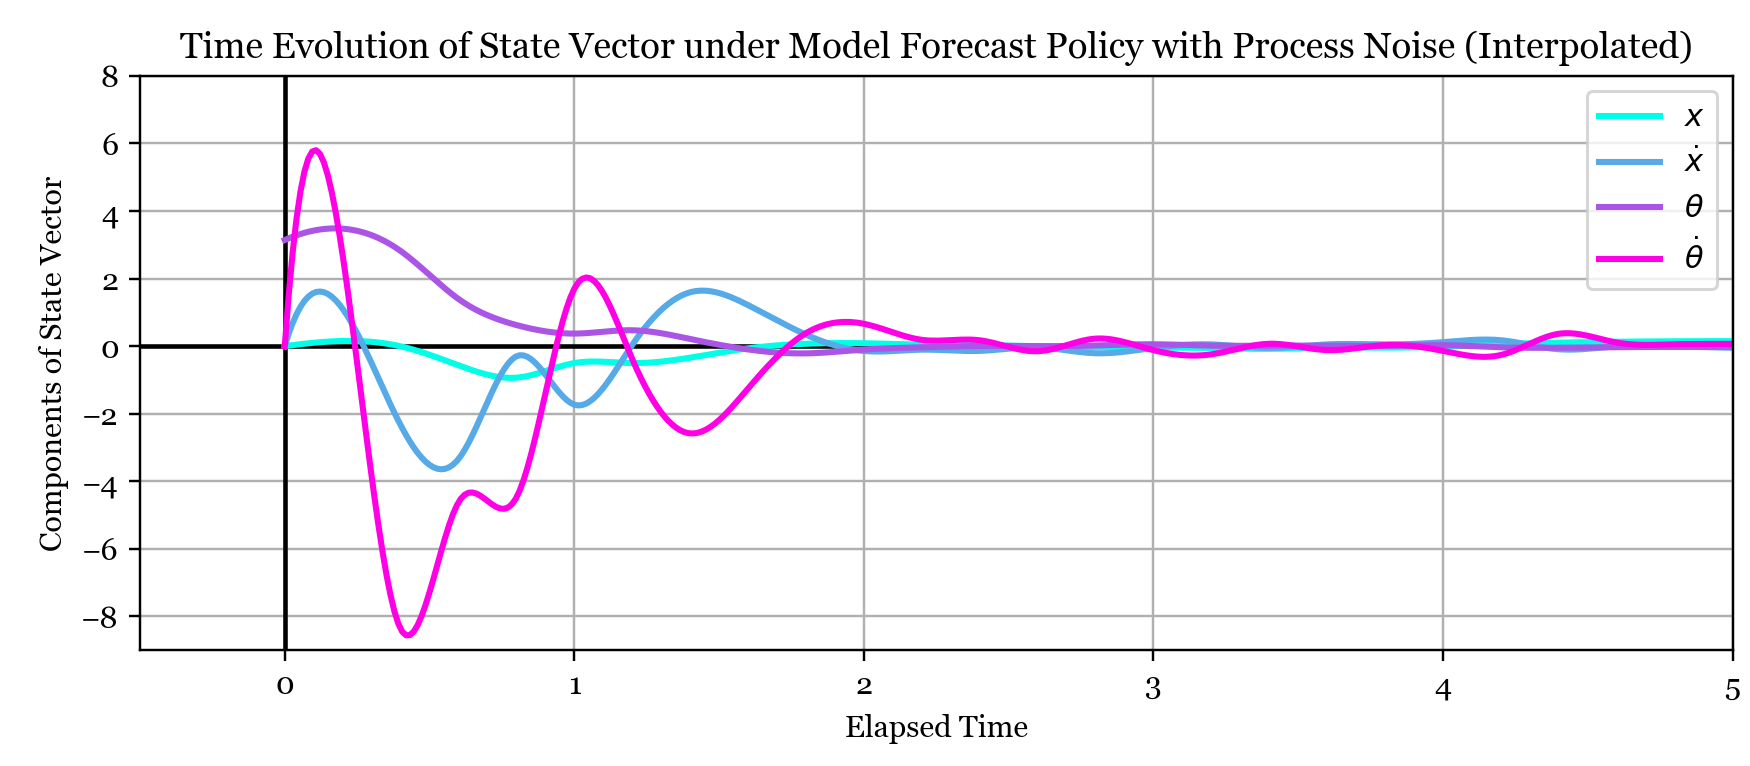

In [111]:
fig, ax = plt.subplots(1, 1, num=33, figsize=(8,3.5))
fig.subplots_adjust(top=0.9, bottom=0.15, left=0.08, right=0.99)
sf3utility.setup_phase_portrait( ax )

np.random.seed(0)

states = []
times = []
t = 0

means = np.array([ 2.00951924, 1.964584, 1.98959769, 4.76029465, 0. ])
noise_level = 0.01

state = np.array( [ 0, 0, np.pi, 0, 0 ] )
cart_pole.set_state( state )
cart_pole._render()

for i in range(200):
    
    states.append(state)
    times.append(t)
    t += 0.2
    
    state[4] = forces[i]
    
    state = CartPole.perform_action_RK4( state )
    cart_pole.set_state( state[:4] )
    cart_pole._render()
    
    state += np.random.randn( 5 ) * means * noise_level
    
    if abs(CartPole.remap_angle(state[2])) < 0.4 and abs(state[1]) < 2.5 and abs(state[3]) < 2.5:
        break

linear_p = np.array( [0.75971638, 1.44284499, 17.05744679, 2.66183469] )
    
for i in range(50):
    
    states.append(state)
    times.append(t)
    t += 0.2
    
    clipped_state = state[:]
    clipped_state[0] = np.clip(clipped_state[0], -0.5, 0.5)

    state[4] = linear_p @ clipped_state[:4]
    
    
    state = CartPole.perform_action_RK4( state )
    cart_pole.set_state( state[:4] )
    cart_pole._render()
    
    state += np.random.randn( 5 ) * means * noise_level
    
states = np.array( states )
times = np.array( times )

x = times
y = states

col_lerp = np.linspace(0, 1, 4)[np.newaxis].T
colours = ( 1 - col_lerp ) * np.array( [0, 255, 231, 255] )/255 + col_lerp * np.array( [255, 0, 230, 255] )/255

labels = ["$x$","$\dot{x}$","$θ$","$\dot{θ}$"]

for i in range(4):
    
    f2 = scipy.interpolate.interp1d(x, y[:,i], kind='cubic')

    xnew = np.linspace(0, times[-1], 800)
    
    ax.plot( xnew, f2(xnew), color=colours[i], label=labels[i], linewidth=2 )

ax.set_title( "Time Evolution of State Vector under Model Forecast Policy with Process Noise (Interpolated)" )
ax.set_xlabel( "Elapsed Time" )
ax.set_ylabel( "Components of State Vector" )
ax.set_xlim(-0.5,5)
ax.set_ylim(-9,8)
ax.legend(loc="upper right")

In [68]:
np.array(states).shape[0]*0.2

31.8